In [119]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

from scipy import stats

import pandas as pd
import numpy as np
import bnlearn as bn

import matplotlib.pyplot as plt

#### Reading Data

In [70]:
# Endorsements are binarized. 
df = pd.read_csv('average_donations.csv')

In [71]:
df.loc[0]

Primary-general indicator                             P2018
Candidate ID                                      H8GA07144
Chamber Endorsed?                                         0
Main Street Endorsed?                                     0
Tea Party Endorsed?                                       0
House Freedom Support?                                    0
Koch Support?                                             0
Club for Growth Endorsed?                                 0
Susan B. Anthony Endorsed?                                0
Right to Life Endorsed?                                   0
NRA Endorsed?                                             0
Great America Endorsed?                                   0
Bannon Endorsed?                                          0
Trump Endorsed?                                           0
Rep Party Support?                                        0
No Labels Support?                                        0
VoteVets Endorsed?                      

In [72]:
prop_vote = df['Primary %']

#### Choosing strong priors based on distribution

In [73]:
# source: https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations

In [74]:
def plot_prior(heading):
  """
  Args:
    heading: heading of a column in average_donations.csv. String.
  Returns:
    mean: mean of prior
    var: variance of prior
  """
  col = df[heading]
  mean = np.mean(col)
  var = np.var(col)
  ax = col.plot.kde()
  print("***Prior***:", heading)
  print("Mean:", mean, "\nVariance:", var)
  plt.xlabel(heading)
  plt.show()
  return mean, var

In [75]:
# choose top ten priors sorted by how uncentered from 0 the mean of the prior is
frames = [df.iloc[:, 2:34], df.iloc[:, 37], df.iloc[:, 46]]
priors = pd.concat(frames, axis = 1)
priors = abs(priors.mean()).sort_values(ascending = False)[0:10]
priors = np.array(priors.index)
priors

array(['Avg Donation Size', 'Partisan Lean', 'Guns Sense Candidate?',
       'STEM?', 'Elected Official?', 'Rep Party Support?',
       'Emily Endorsed?', 'Our Revolution Endorsed?', 'Veteran?',
       'Party Support?'], dtype=object)

In [76]:
priors_df = df.filter(items = priors)

***Prior***: Avg Donation Size
Mean: 6090.644308060757 
Variance: 204284421.0913531


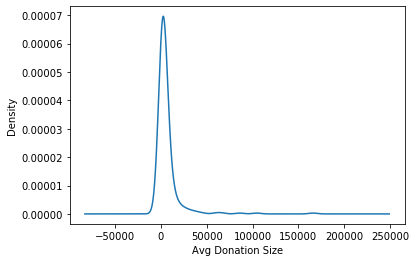

***Prior***: Partisan Lean
Mean: -5.414247475418059 
Variance: 258.019779240901


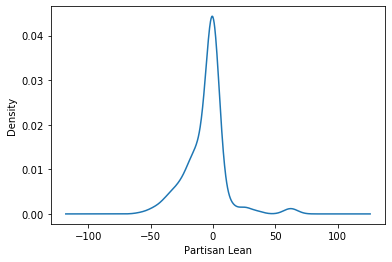

***Prior***: Guns Sense Candidate?
Mean: 0.20735785953177258 
Variance: 0.16436057762217482


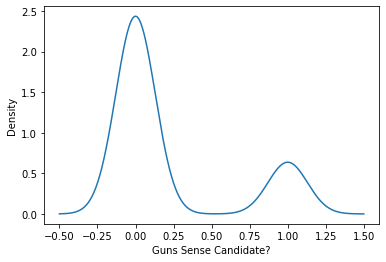

***Prior***: STEM?
Mean: 0.12374581939799331 
Variance: 0.10843279157951319


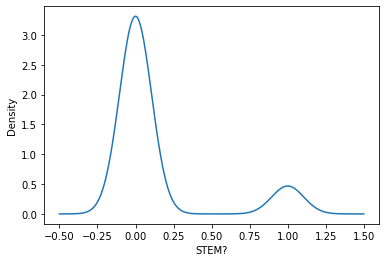

***Prior***: Elected Official?
Mean: 0.11371237458193979 
Variance: 0.10078187044887617


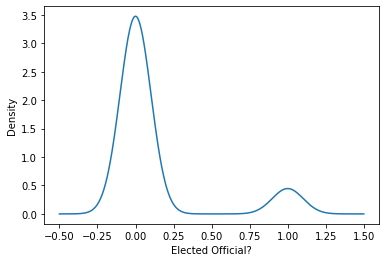

***Prior***: Rep Party Support?
Mean: 0.11036789297658862 
Variance: 0.09818682117649742


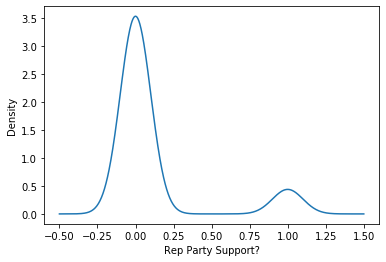

***Prior***: Emily Endorsed?
Mean: 0.09698996655518395 
Variance: 0.0875829129428079


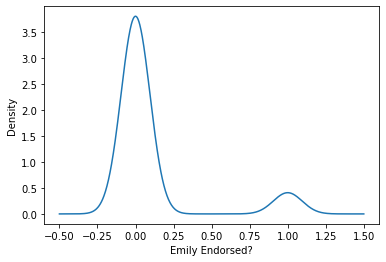

***Prior***: Our Revolution Endorsed?
Mean: 0.0903010033444816 
Variance: 0.08214673213946118


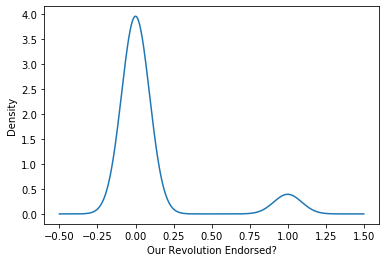

***Prior***: Veteran?
Mean: 0.07357859531772576 
Variance: 0.06816478562879602


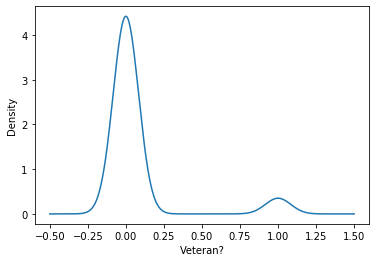

***Prior***: Party Support?
Mean: 0.07357859531772576 
Variance: 0.06816478562879566


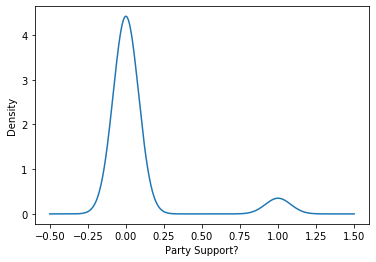

In [77]:
# distributions of the ten priors
for prior in priors_df:
  plot_prior(prior)

#### Modeling

In [81]:
# A: a candidate’s average donation size, 'Avg Donation Size'
# B: the proportion of the vote received, 'Primary %'

In [130]:
# in what structure?
model = BayesianModel([(priors[0], priors[1]), (priors[1], priors[2]), (priors[2], priors[3]), (priors[3], 'Primary %')])

In [84]:
model.fit(df)

In [85]:
inference = VariableElimination(model)

In [126]:
# int(np.mean(df[priors[0]])) errors out
q = inference.query(variables = ['Primary %'], evidence = {'Avg Donation Size': int(np.mean(df[priors[0]]) / 100)})

Eliminating: STEM?: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 187.59it/s]


In [132]:
print(q)

+-------------------------------+------------------+
| Primary %                     |   phi(Primary %) |
+===============================+==================+
| Primary %(0.0)                |           0.0123 |
+-------------------------------+------------------+
| Primary %(1.6)                |           0.0027 |
+-------------------------------+------------------+
| Primary %(2.3)                |           0.0034 |
+-------------------------------+------------------+
| Primary %(2.48)               |           0.0034 |
+-------------------------------+------------------+
| Primary %(3.01)               |           0.0027 |
+-------------------------------+------------------+
| Primary %(3.76)               |           0.0034 |
+-------------------------------+------------------+
| Primary %(3.78)               |           0.0027 |
+-------------------------------+------------------+
| Primary %(3.8)                |           0.0034 |
+-------------------------------+-------------